In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc, cost_functions
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [2]:
comp_points = [[1., 0.5], [2.8, 1.6], [3., 0.5], [2., 0.5]]

### use 0 to make 1 oscillate

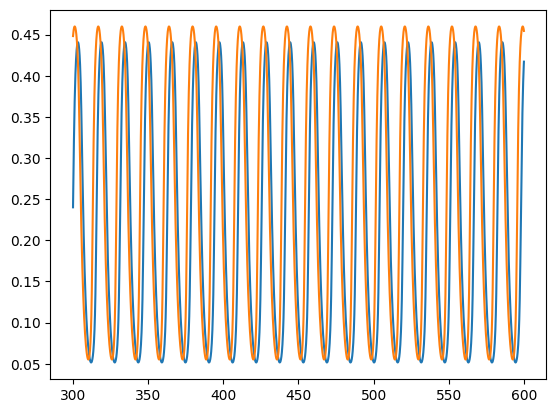

target oscillation period =  23.52
118


In [78]:
cmat = np.array( [[0., 0.], [1., 0.]] ) # diagonal elements are zero, connection strength is 1 from node 0 to node 1
dmat = np.array( [[0., 0.], [10., 0.]] ) # delay from 0 to 1

controlmat = np.zeros((2,2))
controlmat[0,0] = 1.

costmat = np.array( [[0., 0.], [1., 0.]] )

model = WCModel(Cmat=cmat, Dmat=dmat)

dt = 0.1
model.params['dt'] = dt # Integration time step, ms
model.params['duration'] = 1. * 1000 # Simulation time, ms
model.params["exc_ext"] = 2.
model.params["inh_ext"] = 0.5
model.params.signalV = 1.

model.run()

peaks = scipy.signal.find_peaks(model.exc[0,100:])[0]
plist = []
for pind in range(1, len(peaks)):
    plist.append(model.params.dt * (peaks[pind]-peaks[pind-1]))

period = np.around(np.mean(plist),2)

plt.plot(model.t[3000:6000], model.exc[0,3000:6000])
plt.plot(model.t[3000:6000], model.exc[1,3000:6000])
plt.show()

duration = 200.
model.params.duration = duration
zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( (zero_input0, zero_input0))
zero_control0 = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
zero_control = np.vstack( (zero_control0, zero_control0))

results = dict()
w2_array = [1e-3, 1e-5]
results["controls"] =  [ [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ] ]

target_period = 1.5*period
print("target oscillation period = ", target_period)
int0 = int( (duration - 8. * target_period) / model.params.dt)
print(int0)

max delay =  100
Optimal control with target oscillation period
L2 cost weight =  0.001
Compute control for a deterministic system
Cost in iteration 0: -5.410333228290105e-19
Cost in iteration 10: -0.02415558712908119
Converged in iteration 13 with cost -0.024211406332768175
Final cost : -0.024211406332768175


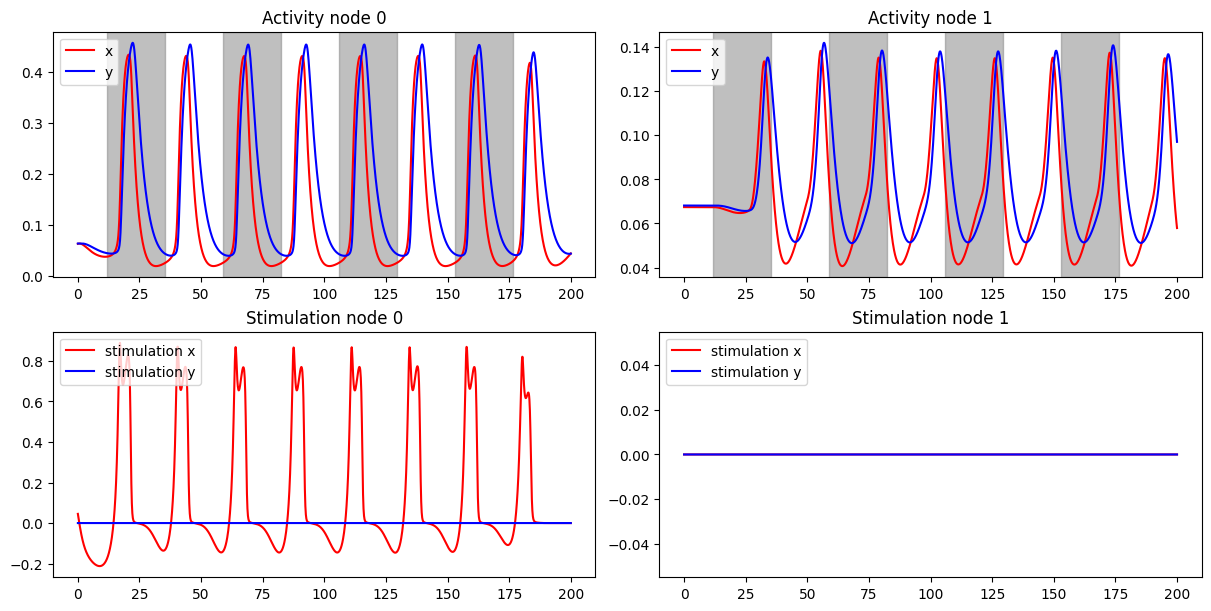

Optimal control with target oscillation period
L2 cost weight =  1e-05
Compute control for a deterministic system
Cost in iteration 0: -5.410333228290105e-19
Cost in iteration 10: -0.0462407910232131
Converged in iteration 17 with cost -0.046467928511219427
Final cost : -0.046467928511219427


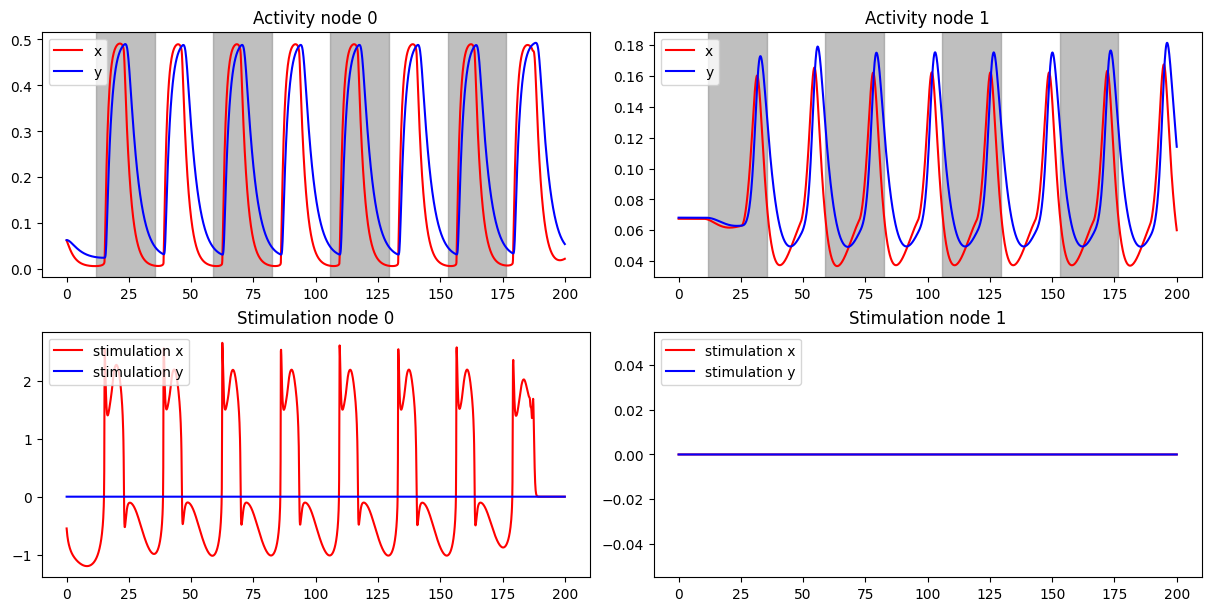

In [79]:
it = 100
pr = np.arange(0,101,10)
maxstr = 5.

pind = 0
p = comp_points[pind]
model.params["exc_ext"] = zero_input + p[0]
model.params["inh_ext"] = zero_input + p[1]
testd = 1000.
model.params.duration = testd
model.run()

e0 = model.exc[0,-1]
e1 = model.exc[1,-1]
i0 = model.inh[0,-1]
i1 = model.inh[1,-1]

nmaxdel = model.getMaxDelay()
print("max delay = ", nmaxdel)
e0stack = [e0] * (nmaxdel+1)
e1stack = [e1] * (nmaxdel+1)
i0stack = [i0] * (nmaxdel+1)
i1stack = [i1] * (nmaxdel+1)

model.params.duration = duration

model.params["exc_init"] = np.array([e0stack, e1stack])
model.params["inh_init"] = np.array([i0stack, i1stack])

for iw in range(len(w2_array)):
    w2 = w2_array[iw]

    if iw not in [0,1]:
        continue

    model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), cost_matrix=costmat, control_matrix = controlmat)
    model_controlled.maximum_control_strength = maxstr
    model_controlled.weights["w_p"] = 0.
    model_controlled.weights["w_f"] = 1.
    model_controlled.weights["w_2"] = w2
    print("L2 cost weight = ", w2)

    if type(results["controls"][pind][iw]) != type(None):
        model_controlled.control = results["controls"][pind][iw]
        model_controlled.update_input()

    model_controlled.optimize(it)
    results["controls"][pind][iw] = model_controlled.control.copy()

    plot_oc_network(2, duration, dt, model_controlled.get_xs(), target_period,  model_controlled.control)

### use 0 to make both oscillate

In [90]:
cmat = np.array( [[0., 0.], [1., 0.]] ) # diagonal elements are zero, connection strength is 1 from node 0 to node 1

controlmat = np.zeros((2,2))
controlmat[0,0] = 1.
controlmat[1,0] = 1.

costmat = np.array( [[1., 0.], [1., 0.]] )

model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.signalV = 1.

duration = 200.
model.params.duration = duration

results = dict()
w2_array = [1e-3, 1e-5]
results["controls"] =  [ [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ] ]

--------------------------------
--------------------------------
--------------------------------
POINT :  [1.0, 0.5]
Target period =  23.52
Optimal control with target oscillation period
L2 cost weight =  0.001
Compute control for a deterministic system
Cost in iteration 0: -3.5091405569558954e-11
20.0 [[20.  0.]
 [20.  0.]]
-0.00020193691299158376 [[-1.12133782e-04 -3.50914056e-11]
 [-1.77647843e-04 -3.50914056e-11]]
Final cost : -0.00020193691299158376


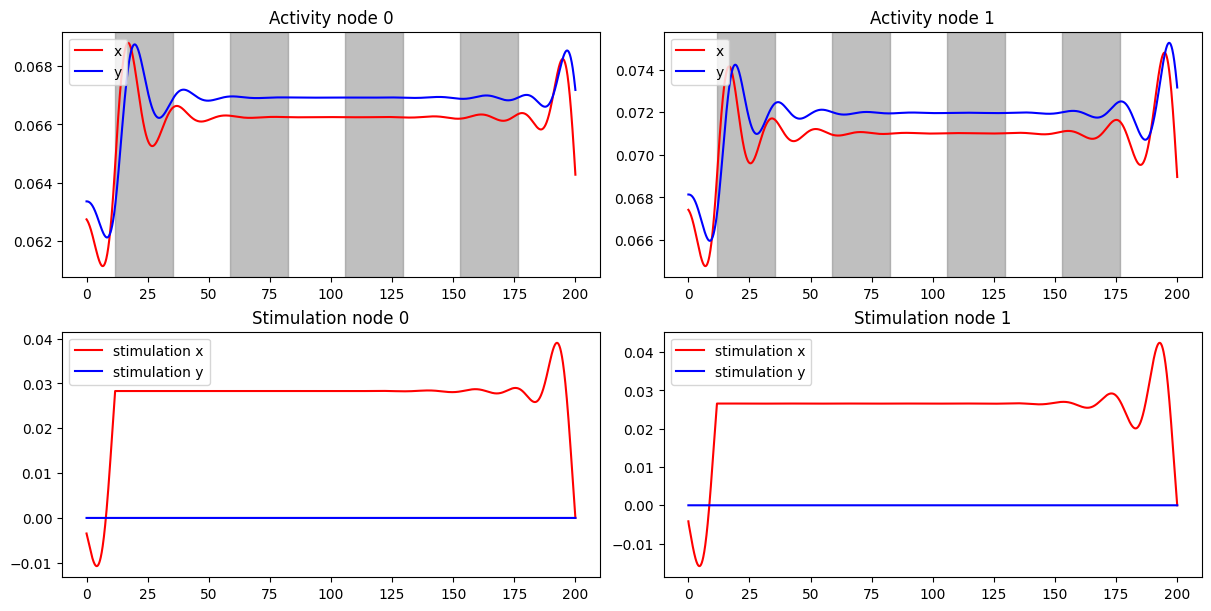

Optimal control with target oscillation period
L2 cost weight =  1e-05
Compute control for a deterministic system
Cost in iteration 0: -3.5091405569558954e-11
20.0 [[20.  0.]
 [20.  0.]]
-0.0003466443898019442 [[-1.88262156e-04 -3.50914056e-11]
 [-2.46226945e-04 -3.50914056e-11]]
Final cost : -0.0003466443898019442


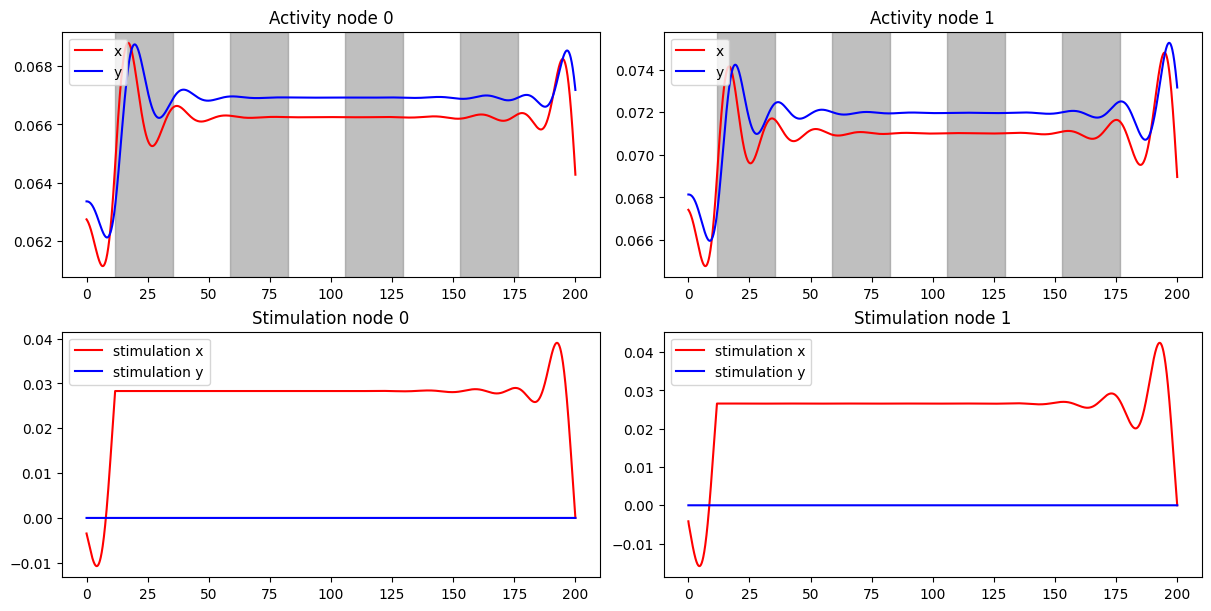

--------------------------------
--------------------------------
--------------------------------
POINT :  [2.8, 1.6]
Target period =  23.52
--------------------------------
--------------------------------
--------------------------------
POINT :  [3.0, 0.5]
Target period =  23.52
--------------------------------
--------------------------------
--------------------------------
POINT :  [2.0, 0.5]
Target period =  23.52


In [91]:
it = 1
pr = np.arange(0,101,10)
maxstr = 5.

for pind in range(len(comp_points)):
    p = comp_points[pind]
    print("--------------------------------")
    print("--------------------------------")
    print("--------------------------------")
    print("POINT : ", p)
    print("Target period = ", target_period)

    if pind not in [0]:
        continue

    model.params["exc_ext"] = zero_input + p[0]
    model.params["inh_ext"] = zero_input + p[1]
    model.run()

    model.params["exc_init"] = np.vstack( [model.exc[0,-1], model.exc[1,-1]] )
    model.params["inh_init"] = np.vstack( [model.inh[0,-1], model.inh[1,-1]] )

    for iw in range(len(w2_array)):
        w2 = w2_array[iw]

        if iw not in [0,1]:
            continue

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), cost_matrix=costmat, control_matrix = controlmat)
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_f"] = 1.
        model_controlled.weights["w_2"] = w2
        print("L2 cost weight = ", w2)

        if type(results["controls"][pind][iw]) != type(None):
            model_controlled.control = results["controls"][pind][iw]
            model_controlled.update_input()

        model_controlled.optimize(it)
        results["controls"][pind][iw] = model_controlled.control.copy()

        plot_oc_network(2, duration, dt, model_controlled.get_xs(), target_period,  model_controlled.control)

### use 0 to synchronize

In [82]:
model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.signalV = 1.

duration = 200.
model.params.duration = duration

results = dict()
w2_array = [1e-3, 1e-5]
results["controls"] =  [ [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ] ]

--------------------------------
--------------------------------
--------------------------------
POINT :  [1.0, 0.5]
Target period =  23.52
Optimal control with target oscillation period
L2 cost weight =  0.001
Compute control for a deterministic system
Cost in iteration 0: -0.16219980585238397
Converged in iteration 7 with cost -0.16219980585238397
Final cost : -0.16219980585238397


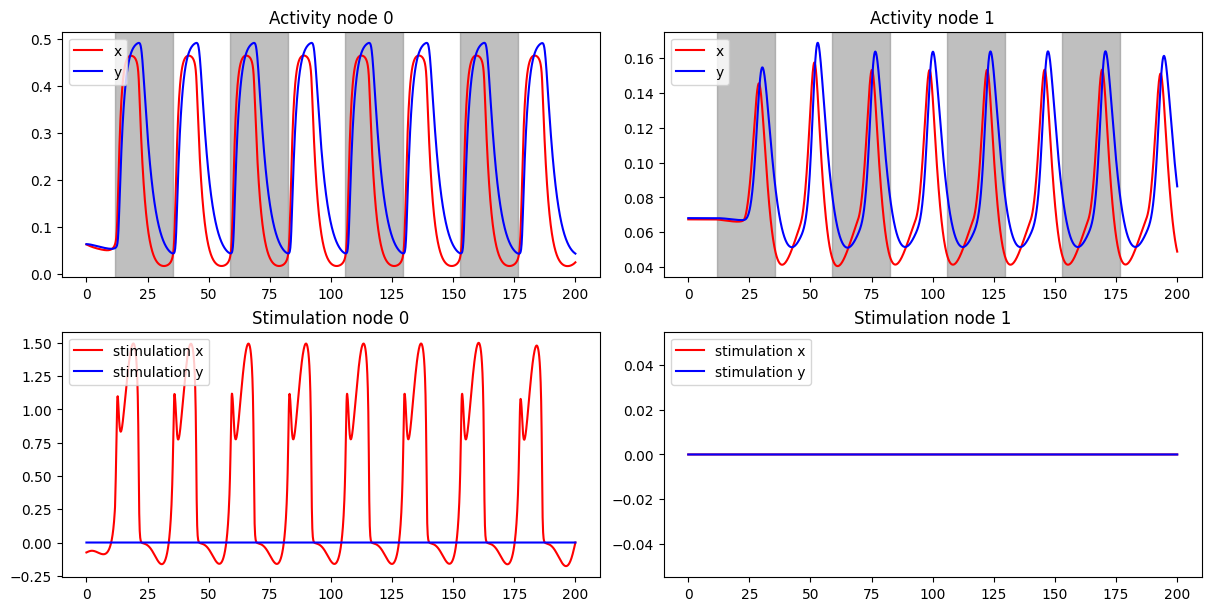

Optimal control with target oscillation period
L2 cost weight =  1e-05
Compute control for a deterministic system
Cost in iteration 0: -0.2571803145574435
Converged in iteration 9 with cost -0.2571803145574435
Final cost : -0.2571803145574435


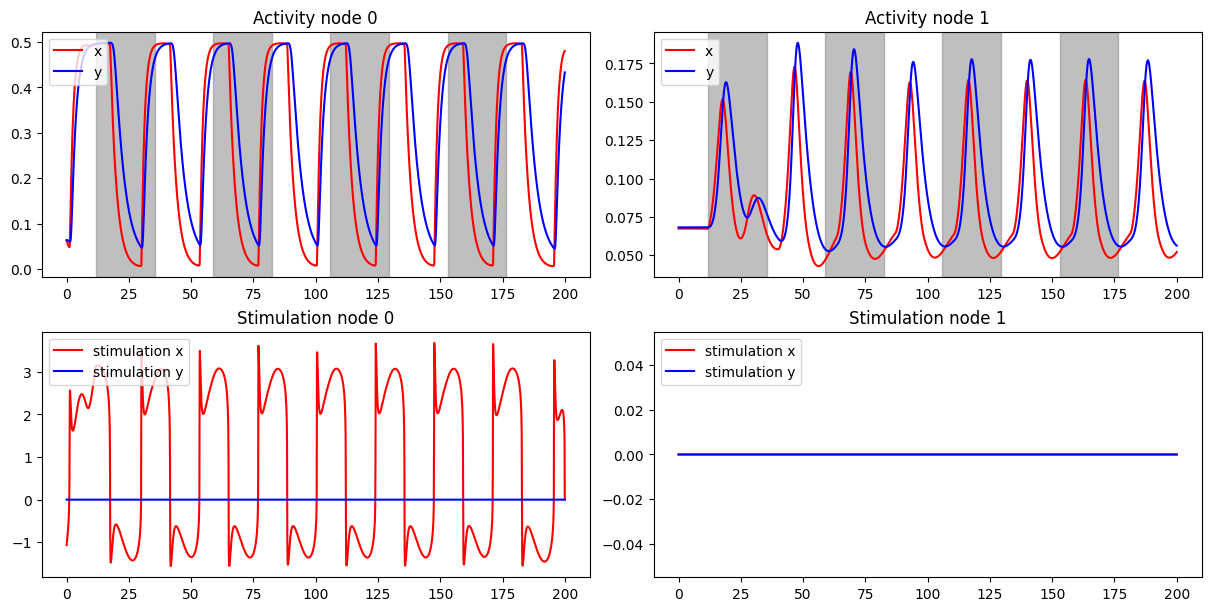

--------------------------------
--------------------------------
--------------------------------
POINT :  [2.8, 1.6]
Target period =  23.52
--------------------------------
--------------------------------
--------------------------------
POINT :  [3.0, 0.5]
Target period =  23.52
--------------------------------
--------------------------------
--------------------------------
POINT :  [2.0, 0.5]
Target period =  23.52


In [84]:
it = 100
pr = np.arange(0,101,10)
maxstr = 5.

for pind in range(len(comp_points)):
    p = comp_points[pind]
    print("--------------------------------")
    print("--------------------------------")
    print("--------------------------------")
    print("POINT : ", p)
    print("Target period = ", target_period)

    if pind not in [0]:
        continue

    model.params["exc_ext"] = zero_input + p[0]
    model.params["inh_ext"] = zero_input + p[1]
    model.run()

    model.params["exc_init"] = np.vstack( [model.exc[0,-1], model.exc[1,-1]] )
    model.params["inh_init"] = np.vstack( [model.inh[0,-1], model.inh[1,-1]] )

    for iw in range(len(w2_array)):
        w2 = w2_array[iw]

        if iw not in [0,1]:
            continue

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), cost_matrix=costmat, control_matrix = controlmat)
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_f_sync"] = 1.
        model_controlled.weights["w_2"] = w2
        print("L2 cost weight = ", w2)

        if type(results["controls"][pind][iw]) != type(None):
            model_controlled.control = results["controls"][pind][iw]
            model_controlled.update_input()

        model_controlled.optimize(it)
        results["controls"][pind][iw] = model_controlled.control.copy()

        plot_oc_network(2, duration, dt, model_controlled.get_xs(), target_period,  model_controlled.control)

### Use 0 to phase-lock

In [85]:
model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.signalV = 1.

duration = 200.
model.params.duration = duration

results = dict()
w2_array = [1e-3, 1e-5]
results["controls"] =  [ [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ] ]

--------------------------------
--------------------------------
--------------------------------
POINT :  [1.0, 0.5]
Target period =  23.52
Optimal control with target oscillation period
L2 cost weight =  0.001
Compute control for a deterministic system
Cost in iteration 0: -4.098646222847761e-11
Cost in iteration 10: -0.23834133147247524
Cost in iteration 20: -0.24051002157007087
Cost in iteration 30: -0.24059206794870958
Cost in iteration 40: -0.24063038456620464
Cost in iteration 50: -0.24066019726507176
Cost in iteration 60: -0.24068528467825684
Cost in iteration 70: -0.2407065150425889
Cost in iteration 80: -0.24072489937329403
Cost in iteration 90: -0.2407405070197624
Cost in iteration 100: -0.24075373899996522
Final cost : -0.24075373899996522


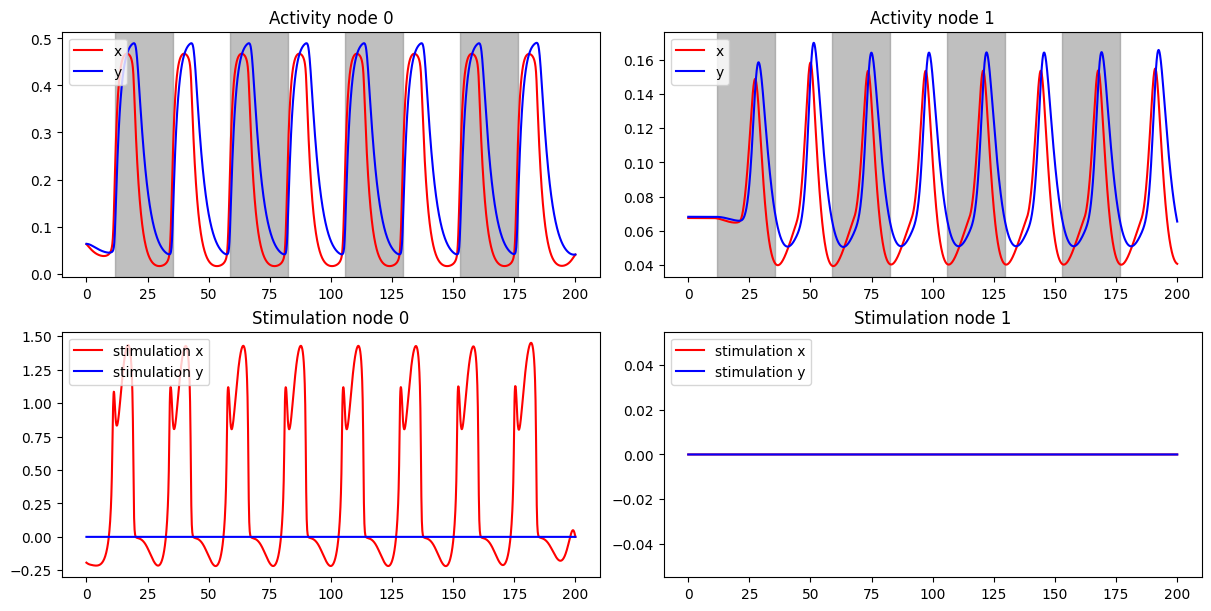

Optimal control with target oscillation period
L2 cost weight =  1e-05
Compute control for a deterministic system
Cost in iteration 0: -4.098646222847761e-11
Cost in iteration 10: -0.3247842653178147
Cost in iteration 20: -0.3251045919333979
Converged in iteration 26 with cost -0.3251046389632833
Final cost : -0.3251046389632833


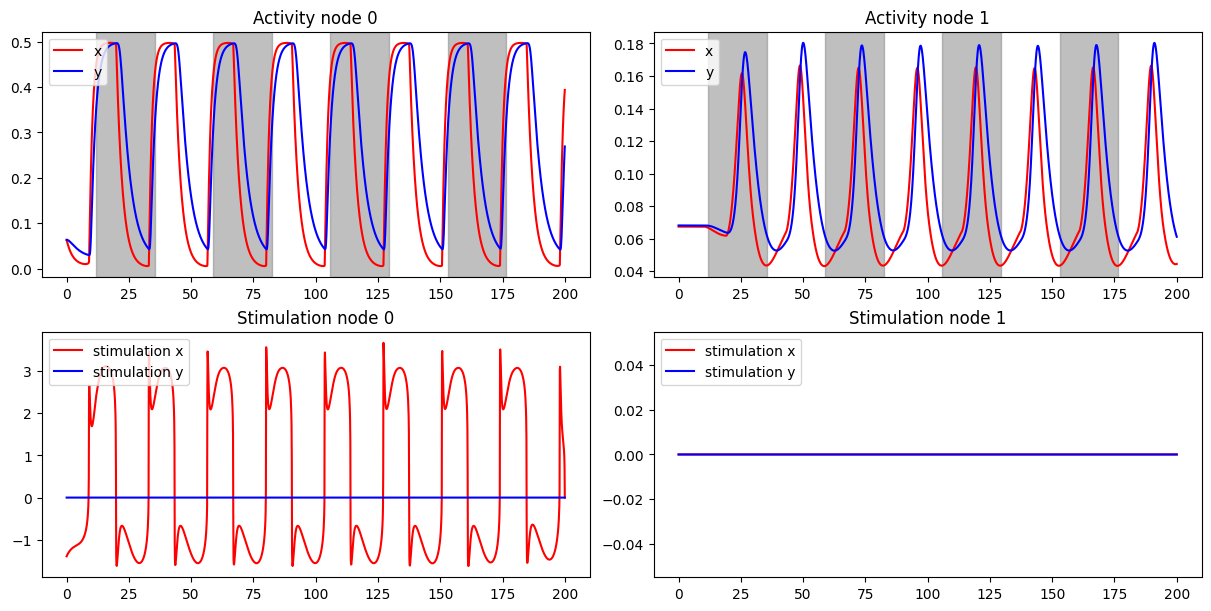

--------------------------------
--------------------------------
--------------------------------
POINT :  [2.8, 1.6]
Target period =  23.52
--------------------------------
--------------------------------
--------------------------------
POINT :  [3.0, 0.5]
Target period =  23.52
--------------------------------
--------------------------------
--------------------------------
POINT :  [2.0, 0.5]
Target period =  23.52


In [86]:
it = 100
pr = np.arange(0,101,10)
maxstr = 5.

for pind in range(len(comp_points)):
    p = comp_points[pind]
    print("--------------------------------")
    print("--------------------------------")
    print("--------------------------------")
    print("POINT : ", p)
    print("Target period = ", target_period)

    if pind not in [0]:
        continue

    model.params["exc_ext"] = zero_input + p[0]
    model.params["inh_ext"] = zero_input + p[1]
    model.run()

    model.params["exc_init"] = np.vstack( [model.exc[0,-1], model.exc[1,-1]] )
    model.params["inh_init"] = np.vstack( [model.inh[0,-1], model.inh[1,-1]] )

    for iw in range(len(w2_array)):
        w2 = w2_array[iw]

        if iw not in [0,1]:
            continue

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), cost_matrix=costmat, control_matrix = controlmat)
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_f_pl"] = 1.
        model_controlled.weights["w_2"] = w2
        print("L2 cost weight = ", w2)

        if type(results["controls"][pind][iw]) != type(None):
            model_controlled.control = results["controls"][pind][iw]
            model_controlled.update_input()

        model_controlled.optimize(it)
        results["controls"][pind][iw] = model_controlled.control.copy()

        plot_oc_network(2, duration, dt, model_controlled.get_xs(), target_period,  model_controlled.control)